In [231]:
# setup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import sys
sys.path.append('../')
from clean_chords import *
%matplotlib inline

Now, overall we have ~1.3M entries in the chords table and ~91k songs in the metadata table (but don't get excited yet), and since these are all broken down by Gracenote ID it should be straightforward to connect this with our  data (once Kris has finished joining everything)

In [325]:
# read in raw data 
chords = pd.read_table('../data/chords/song_chord.tsv',usecols=[1,2,3,4])
metadata = pd.read_table('../data/chords/song_metadata.tsv',usecols=[1,2,3,4])

# total raw data length
print len(chords),len(metadata)


13330638 91428


Another former IU colleague shared some simple cleaning code that resolves the raw "chord" column in the above table to a root chord, a chord type, and a standardized name for each unique chord. Some examples:

In [233]:
to_test = ['Amin','Am','AM','A*','A7*','A#aug','BbM7', 'GM','Gmaj7','G5', 'blah','INVALID']
for t in to_test:
    print 'Chord %5s mapped to root=%2s, type=%6s, stdname=%5s' % (t, chord2root(t), chord2type(t), stdname(t))

Chord  Amin mapped to root= A, type= minor, stdname=   Am
Chord    Am mapped to root= A, type= minor, stdname=   Am
Chord    AM mapped to root= A, type= major, stdname=    A
Chord    A* mapped to root= A, type= major, stdname=    A
Chord   A7* mapped to root= A, type=  dom7, stdname=   A7
Chord A#aug mapped to root=A#, type=   aug, stdname=A#aug
Chord  BbM7 mapped to root=Bb, type=major7, stdname= BbM7
Chord    GM mapped to root= G, type= major, stdname=    G
Chord Gmaj7 mapped to root= G, type=major7, stdname=  GM7
Chord    G5 mapped to root= G, type= power, stdname=   G5
Chord  blah mapped to root=INVALID, type=INVALID, stdname=INVALID
Chord INVALID mapped to root=INVALID, type=INVALID, stdname=INVALID


In [327]:
# format chord data with Artemy's cleaning code
chords['root'] = chords.chord.apply(lambda x: chord2root(x))
chords['type'] = chords.chord.apply(lambda x: chord2type(x))
chords['stdname'] = chords.chord.apply(lambda x: stdname(x))


In [328]:
chords.head()

,songID,locID,chord,chordType,root,type,stdname
0,0,1,C#,major,C#,major,C#
1,0,2,A,major,A,major,A
2,0,3,C#,major,C#,major,C#
3,0,4,A,major,A,major,A
4,0,5,B,major,B,major,B


Now, to get a more meaningful look at things, I started with a simple heuristic: Limit analysis to songs with (a) at least 10 valid chord entries and (b) where the total proportion of invalid chords was less than 10% of the total chords for that song. Of course we can tweak these values, but it seemed a reasonable starting point.

In [236]:
# get song coverage info (i.e. total number of chords per song, and number of invalid chords per song)
song_coverage = chords.groupby('songID').apply(lambda x: pd.Series([len(x),len(x[x.chordType=='INVALID'])],index=['n','invalid']))
joined = metadata.join(song_coverage,on='songID',how='inner')
joined.head()

,songID,GNID,gn_artist,gn_song,n,invalid
0,0,208659287-3D1452F255934F4BF1021EDC9795B764,009 Sound System,Speak To Angels,24,0
1,1,7295343-FD308EFDE84AC10B32414095DB4CAAAE,"10,000 Maniacs",A Campfire Song,26,0
2,5,7411946-9D409CE02704BD0D79C5838E1E016958,"10,000 Maniacs",Everyone A Puzzle Lover,5,0
3,6,7295341-3C430BB4CA9E433705B0D4DE66E736EA,"10,000 Maniacs",Gun Shy,89,0
4,7,4296604-FD5D213C43C45E5FB47C9146D1105014,"10,000 Maniacs",How You've Grown,84,0


In [238]:
# select only those songs where less than 10% of all chords are invalid and there are at least 10 valid chords
trimmed = joined[((joined.invalid.astype(float)/joined.n)<.1)&((joined.n-joined.invalid)>=10)].reset_index(drop=True)
# join everything together
final = chords.join(trimmed.set_index('songID'),on='songID',how='inner')

This brings us to 4.3M chord events (with 189 unique chord types) across ~72k songs and 12.5k unique artists:

In [254]:
print len(final),len(final.stdname.unique()),len(final.songID.unique()),len(final.gn_artist.unique())

4308943 189 72930 12560


Now, the overall distribution of chord types is heavy tailed, but here's the distribution of the top 100 most ocmmon chords (across all songs):

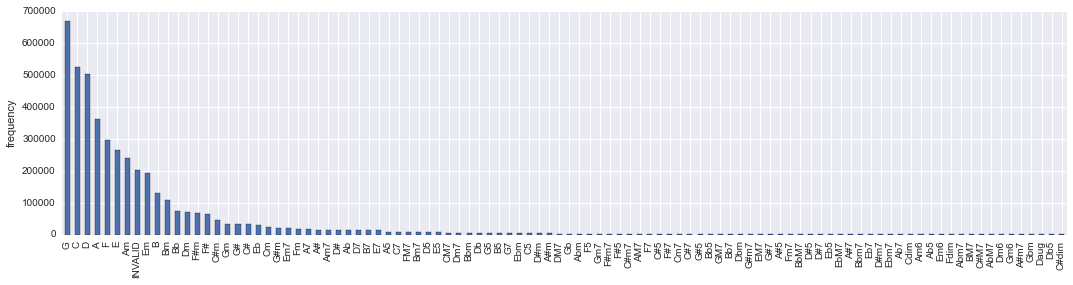

In [258]:
fig,ax=plt.subplots(1,1,figsize=(18,4))
final['stdname'].value_counts()[:100].plot(kind='bar',ax=ax)
ax.set_ylabel('frequency');

And here we have the distribution of number of chord events per song (log-log scale here):

count    72930.000000
mean        59.083203
std         45.158653
min         10.000000
25%         32.000000
50%         53.000000
75%         77.000000
max       2360.000000
Name: chord, dtype: float64


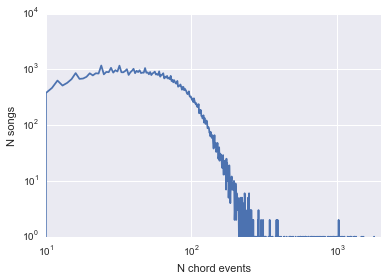

In [268]:
countBySong = final.groupby('songID')['chord'].count()
print countBySong.describe()
bins = np.arange(0,2000,1)
fig,ax = plt.subplots(1,1)
ax.plot(np.histogram(countBySong,bins=bins)[0])
ax.set_xlabel('N chord events'); ax.set_ylabel('N songs')
ax.set_xlim(10,2000)
ax.set_yscale('log')
ax.set_xscale('log');

Now, let's play with this a bit and see if the chord dat is telling us anything coherent. Below I combined all the songs by a few example artists, and build a prob. distribution of all the chords they use across all songs in the data. I repeat this for the unique chords, root chords, and chord types (major, minor, etc.), and in each case compute the pairwise Jensen-Shannon diverges between these prob. distributions. If you don't want to look through the things, the short story is that things aren't super intuitive. AS we would expect, Katy Perry and Britney Spears (2 pop artists) tend to be really similar, but in many cases Motorhead ends up coming up more similar to one of them than it does to Metallica, which is a bit surprising.

Now, whether refelcts a problem with the data, or simply that it does not align to our intuitive, gestalt notions of artist similarity reamins to be seen (and of course this is just looking at a few silly examples). Thoughts appreciated!

I'm also looking into perhaps applying some text mining approaches to the chord data (e.g. think of songs or artists as documents, and chords as words), but I'm skeptical that there's enought data to work with, at least at the song level. At the very least, we have some new features to possibly enrich other analyses.

In [343]:
all_chords = final['stdname'].unique()
all_root_chords = final['root'].unique()
all_chord_types = final['type'].unique()

all_chords = all_chords[all_chords!="INVALID"]
all_root_chords = all_root_chords[all_root_chords!="INVALID"]
all_chord_types = all_chord_types[all_chord_types!="INVALID"]

from scipy.stats import entropy
# jensen shannon devergence
def jsd(p,q):
    p = p / float(p.sum())
    q = q / float(q.sum())
    return entropy((p+q)/2.)-0.5*entropy(p)-.5*entropy(q)

print all_chords
print all_root_chords
print all_chord_types

['C#' 'A' 'B' 'D' 'E' 'F#' 'C' 'G' 'Am' 'C#m' 'Em' 'F' 'Dm' 'Am7' 'Bb' 'Bm'
 'F#m' 'D#' 'G#' 'D5' 'A5' 'C5' 'F5' 'C#5' 'G#5' 'B5' 'Eb' 'A#' 'A#5' 'B7'
 'A7' 'E7' 'Abm' 'Db' 'F#7' 'Gm' 'Cm7' 'F#5' 'E5' 'Cm' 'G#m' 'Bbm' 'Ebm'
 'Fm' 'Ab' 'FM7' 'G5' 'Bb5' 'Bm7' 'Em7' 'Dm7' 'G7' 'CM7' 'F7' 'A#m' 'D#5'
 'D#m' 'D7' 'C#m7' 'C7' 'Ab7' 'Eb5' 'Gb' 'Db5' 'Gbm' 'DM7' 'Ddim' 'Bbm7'
 'Ebm7' 'G#m7' 'G#m6' 'AM7' 'Em6' 'Am6' 'C#7' 'Gm7' 'Daug' 'Fdim' 'D#dim'
 'Fm6' 'Bbm6' 'Bb7' 'GM7' 'EM7' 'F#m7' 'F#dim' 'Dm6' 'G#dim' 'Bm6' 'Dbm'
 'Cdim' 'Fm7' 'DbM7' 'Cb' 'Cm6' 'D#7' 'Aaug' 'Ab5' 'G#7' 'Db7' 'Edim' 'Gm6'
 'F#aug' 'A#7' 'Cdim7' 'G#dim7' 'A#m7' 'EbM7' 'Dbdim' 'Gb7' 'Gbm7' 'C#dim'
 'BbM7' 'BM7' 'G#M7' 'Eb7' 'C#M7' 'D#m7' 'B#dim7' 'F#dim7' 'Abm7' 'Fbm'
 'Ebdim' 'D#M7' 'Gaug' 'A#M7' 'Dbm7' 'Adim7' 'Faug' 'F#M7' 'AbM7' 'C#dim7'
 'Abdim7' 'Bdim' 'Edim7' 'Gdim' 'Dbdim7' 'Ebaug' 'B#m' 'B#' 'Bbdim' 'Eaug'
 'D#aug' 'Adim' 'A#dim' 'Fb5' 'C#m6' 'Abm6' 'Fdim7' 'Baug' 'Ddim7' 'Bbaug'
 'Bdim7' 'Bbdim7' 'Caug' 'C#aug' '

In [344]:
kp = final[final.gn_artist=='Katy Perry'].stdname.value_counts().reindex(all_chords,fill_value=0).values
met = final[final.gn_artist=='Metallica'].stdname.value_counts().reindex(all_chords,fill_value=0).values
bs = final[final.gn_artist=='Britney Spears'].stdname.value_counts().reindex(all_chords,fill_value=0).values
mot = final[final.gn_artist=='Motorhead'].stdname.value_counts().reindex(all_chords,fill_value=0).values

print 'metallica <-> motorhead',jsd(met,mot)
print 'metallica <-> britney spears',jsd(met,bs)
print 'metallica <-> katy perry',jsd(met,kp)
print 'motorhead <-> britney spears',jsd(mot,bs)
print 'motorhead <-> katy perry',jsd(mot,kp)
print 'britney spears <-> katy perry',jsd(bs,kp)


metallica <-> motorhead 0.19379747048
metallica <-> britney spears 0.303834132155
metallica <-> katy perry 0.254598223777
motorhead <-> britney spears 0.25881255273
motorhead <-> katy perry 0.139843052996
britney spears <-> katy perry 0.104297859612


In [345]:
kp = final[final.gn_artist=='Katy Perry']['root'].value_counts().reindex(all_root_chords,fill_value=0).values
met = final[final.gn_artist=='Metallica']['root'].value_counts().reindex(all_root_chords,fill_value=0).values
bs = final[final.gn_artist=='Britney Spears']['root'].value_counts().reindex(all_root_chords,fill_value=0).values
mot = final[final.gn_artist=='Motorhead']['root'].value_counts().reindex(all_root_chords,fill_value=0).values

print 'metallica <-> motorhead',jsd(met,mot)
print 'metallica <-> britney spears',jsd(met,bs)
print 'metallica <-> katy perry',jsd(met,kp)
print 'motorhead <-> britney spears',jsd(mot,bs)
print 'motorhead <-> katy perry',jsd(mot,kp)
print 'britney spears <-> katy perry',jsd(bs,kp)


metallica <-> motorhead 0.058489140026
metallica <-> britney spears 0.0606560100476
metallica <-> katy perry 0.0286677058913
motorhead <-> britney spears 0.165483296041
motorhead <-> katy perry 0.0842959044825
britney spears <-> katy perry 0.0561721778459


In [346]:
kp = final[final.gn_artist=='Katy Perry']['type'].value_counts().reindex(all_chord_types,fill_value=0).values
met = final[final.gn_artist=='Metallica']['type'].value_counts().reindex(all_chord_types,fill_value=0).values
bs = final[final.gn_artist=='Britney Spears']['type'].value_counts().reindex(all_chord_types,fill_value=0).values
mot = final[final.gn_artist=='Motorhead']['type'].value_counts().reindex(all_chord_types,fill_value=0).values

print 'metallica <-> motorhead',jsd(met,mot)
print 'metallica <-> britney spears',jsd(met,bs)
print 'metallica <-> katy perry',jsd(met,kp)
print 'motorhead <-> britney spears',jsd(mot,bs)
print 'motorhead <-> katy perry',jsd(mot,kp)
print 'britney spears <-> katy perry',jsd(bs,kp)


metallica <-> motorhead 0.1340975583
metallica <-> britney spears 0.233418052759
metallica <-> katy perry 0.225600139457
motorhead <-> britney spears 0.0355584782402
motorhead <-> katy perry 0.0371373661088
britney spears <-> katy perry 0.00766636250699
